In [1]:
# import rozneho potrebneho...

%load_ext autoreload
%autoreload

# %matplotlib inline
%matplotlib nbagg

import numpy as np
from scipy.integrate import odeint

import sys
sys.path.append('./misc/')

from figFcns_nb import *

# O meraní prevodovej charakteristiky

Prevodová charakteristika je závislosť ustálených hodnôt výslupnej veličiny od ustálených hodnôt vstupnej veličiny. Zhruba povedané. Prevodová charakteristika, niekde sa nazýva aj statická charakteristika, teda charakterizuje systém len v ustálených stavoch. Neobsahuje informáciu o dynamike systému.

V nasledujúcom sa pokúsime načrtnúť merananie prevodovej charakteristiky - tu však, samozrejme, nie je možné naozaj niečo merať, preto reálny systém bude nahradený simulovaným. Proces získavania „surových“ dát, ktoré sú potrebné pre určenie prevodovej charakteristiky a proces spracovania týchto dát bude však rovnaký akoby isľo o reálny systém.

Systém, ktorý bude predmetom skúmania, ktorého prevodovú charakteristiku budemem merať, je kyvadlo, tak ako bolo už skôr opísané. Funkcia implementujúca diferenciálne rovnice kyvadla a funkcia implementujúca simulačnú schému, sú nasledovné:

In [2]:
def fcn_rovniceKyvadla(x, t, u):

    x_1, x_2 = x

    m = 1
    l = 1
    g = 9.81
    beta = 2 * 1.0 * np.sqrt(g/l)

    dotx_1 = x_2
    dotx_2 = -(beta/(m*l**2)) * x_2 - (g/l) * np.sin(x_1) + (1/(m*l**2)) * u

    return [dotx_1, dotx_2]

In [3]:
def fcn_simSch01(t_start, T_s, finalIndex, u_tabulka):

    #-----------------------------------------
    # casovy vektor

    t_log = np.zeros([finalIndex, 1])
    t_log[0,:] = t_start

    #-----------------------------------------
    # vektor stavu riadeneho systemu

    x_0 = np.array([0, 0])

    x_log = np.zeros([finalIndex, len(x_0)])
    x_log[0,:] = x_0

    #-----------------------------------------
    # vektor akcneho zasahu

    u_log = np.zeros([finalIndex, 1])

    for idx in range(u_log.shape[0]):
        lastValue = u_tabulka[:,1][u_tabulka[:,0] <= idx*T_s ][-1]
        u_log[idx] = lastValue

    #-----------------------------------------

    timespan = np.zeros(2)
    for idx in range(1, int(finalIndex)):

        #-------------------------------------
        # Riadeny system - simulacia (pomocou ODEsolvera)

        timespan[0] = t_log[idx-1,:]
        timespan[1] = t_log[idx-1,:] + T_s

        odeOut = odeint(fcn_rovniceKyvadla,
                        x_log[idx-1,:],
                        timespan,
                        args=(u_log[idx-1,:],)
                        )

        x_log[idx,:] = odeOut[-1,:]
        t_log[idx,:] = timespan[-1]

    # y bude umelo zasumeny vystup
    y = (x_log[:,0].reshape(-1,1)*180/np.pi) + ((np.random.rand(x_log[:,0].shape[0],1)-0.5)*2.5)


    return [t_log, x_log, u_log, y]

### Surové dáta...
Všimnime si, že simulačná schéma očakáva zadanú premennú `u_tabulka`, čo je tabuľka, podľa ktorej sa vytvorí vstupný signál $u(t)$ následne použitý počas simulácie. Táto tabuľka sa predpokladá v nasledovnom tvare: dva stĺpce, prvý stĺpec je čas, v ktorom sa mení hodnota signálu $u(t)$ a druhý stĺpec je hodnota na akú sa mení. Nech je tabuľka takáto:

In [4]:
u_tabulka = np.array([
                [0, 0.0],
                [10, 1.0],
                [20, 2.0],
                [30, 3.0],
                [40, 4.0],
                [50, 5.0],
                [60, 6.0],
                [70, 7.0],
                [80, 8.0],
                [95, 9.0],
                [110, 9.5],
                [135, 9.81],
                [180, 9.81],
                ])

Takto zvolená tabuľka odráža v podstate celý zvolený proces merania prevodovej charakteristiky...

Spustime simuláciu:

In [5]:
# Nastavenia simulacie

sim_t_start = 0
sim_t_final = u_tabulka[-1,0]
sim_T_s = 0.1
sim_finalIndex = int(((sim_t_final - sim_t_start)/sim_T_s) + 1)


# Simulacia
t_log, x_log, u_log, y = fcn_simSch01(sim_t_start, sim_T_s, sim_finalIndex, u_tabulka)

suroveData = np.hstack([t_log, y])

<IPython.core.display.Javascript object>


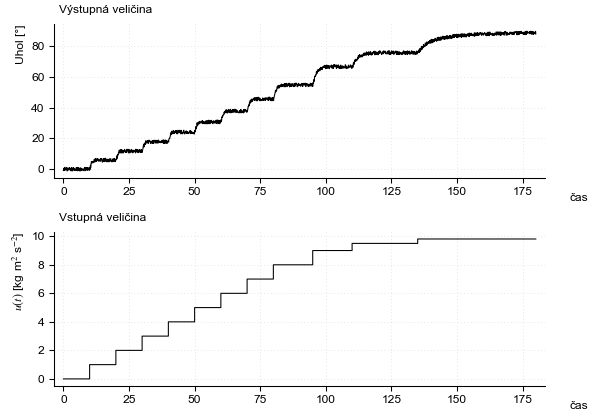

In [6]:
# Obrazok
figNameNum = 1
execfile('misc/figsc_01.py')


### Spracovanie surových dát - odčítanie („z grafu“, z dát) bodov prevodovej charakteristiky:

Predpripravme si ďalší obrázok so surovými dátami, do ktorého budeme kresliť „odčítané“ hodnoty:

<IPython.core.display.Javascript object>


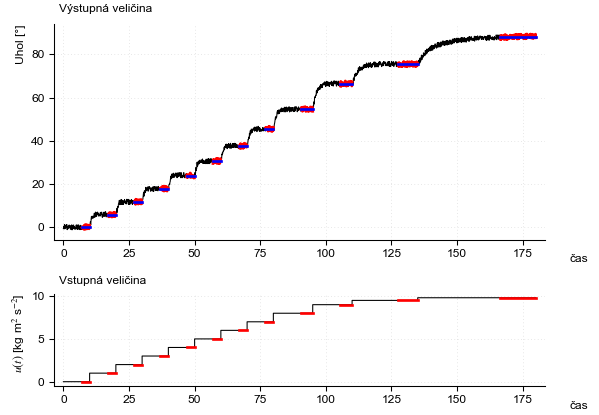

In [7]:
# Obrazok
figNameNum = 2
execfile('misc/figsc_02_part1.py')

Samotný proces odčítavania (a dokreslovania do Figure 2)

In [8]:
prevodChar = np.zeros([u_tabulka.shape[0] - 1, 2])

for idx in range(1, u_tabulka.shape[0]):

    ustVstup =  u_tabulka[idx-1][1]
    ustInterval = [u_tabulka[idx-1][0] + (u_tabulka[idx][0]-u_tabulka[idx-1][0])*0.7,
                   u_tabulka[idx][0]
                   ]

    boolMaska = np.logical_and(suroveData[:,0]>ustInterval[0], suroveData[:,0]<=ustInterval[1])

    ustVystCas = suroveData[boolMaska, 0]
    ustVystHodnoty = suroveData[boolMaska, 1]

    ustPriemer = np.mean(ustVystHodnoty)

    prevodChar[idx-1, 0] = ustVstup
    prevodChar[idx-1, 1] = ustPriemer


    #------------------------------
    # Kreslenie do obrazka:

    ax0.plot(ustVystCas, ustVystHodnoty,
             '-r', lw=2,
             )

    #------------------------------
    ax0.plot(ustInterval, [ustPriemer, ustPriemer],
             '-b', lw=2,
             )
    #------------------------------
    ax1.plot(ustInterval, [ustVstup, ustVstup],
             '-r', lw=2,
             )


Dokončenie obrázka:

In [9]:
execfile('misc/figsc_02_part2.py')

Nakreslenie výslednej prevodovej charakteristiky:

<IPython.core.display.Javascript object>


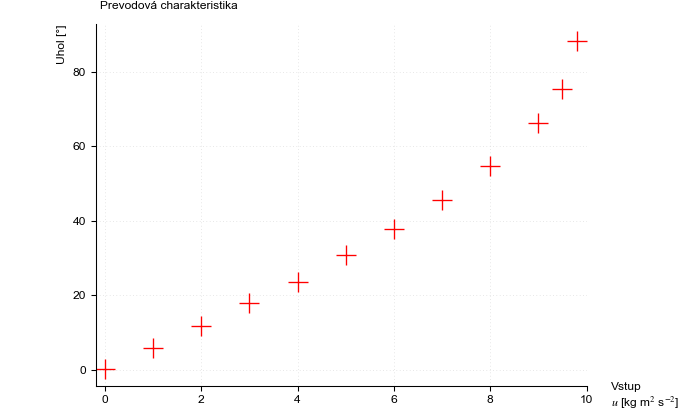

In [10]:
# Obrazok
figNameNum = 3
execfile('misc/figsc_03.py')

Dáta pre tabuľku prevodovej charakteristiky:

In [11]:
print prevodChar
np.savetxt('misc/dataRepo/prevodChar.csv', prevodChar)

[[  0.           0.13205841]
 [  1.           5.75454959]
 [  2.          11.75395613]
 [  3.          17.8801153 ]
 [  4.          23.70033714]
 [  5.          30.7760035 ]
 [  6.          37.70120824]
 [  7.          45.61721009]
 [  8.          54.80695886]
 [  9.          66.27703605]
 [  9.5         75.45929757]
 [  9.81        88.30751803]]
